In [3]:
import numpy as np
import cv2 as cv #opencv - for reading in images
# import os
import data_processing as dp
import storage as tst
import scipy.interpolate as intp
import scipy.fft as fft
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
%matplotlib inline

# constants
c = 2.99e8 # speed of light in vac [m/s]
# factors for plotting, b/c im working in m and sec
h2th = 1.e-15 # Hz to THz
m2nm = 1.e9 # m to nm
s2fs = 1.e15 # s to fs

# FROG Testing

### vanilla SHG FROG

NOTES:

    - need to decide on a fft norm convention, i personally kinda like 'ortho', aka 1/sqrt{N} on both
    - when finding freq or times with fft, times needs df (but is just delays), freq needs dt and is going to have the neg freqs obvs
    - calc traces can be float, but shouldnt be <0, figure out whn to implement checks for that
    - using tau-tau for times and should cover pnts on both sides of tau
    - doing these as all seperate functs is for testing and to store in a large funct that will work faster
    -also need to test when complex and neg numbers show up (at some pnt they have to cuz the output E field is complex)
    - will at some point may want to try and get FT and IFT steps handle padding
    - need to figure out what FT style i should use, it needs to stay consistent
    - ^ spectra should be on the carrier freq, but that ignores the neg freq components
    - see if once i finish putting this shit in a .py file i can do the compiling decorator again and give this shit a speed boost
    - so the E(t) removes the carier freq omega_0, but FT{E} is centered on omega_0 but only contains the positive part. but this is specificallly for after frog
    - use numpy sum for integrals like in creating new iter of E, might wanna do like a partial for it since its already a funct
    - ^ to save mem from importing another mod, just use numpy tabulated integration methods
    - in full program gonna wanna do some sort of check against prev Gk's, maybe use np.diff to check for stagnation

does fft expect the guy centered at 0 freq and should i only do the positive part and if i do what does tht mean???

AS EXPECTED, the fuckin calibration was wrong, although im pretty sure i got the axis right, id need to double check tho, talk to like yassen/liam and do a guesstimate for these guys i guess, once you have a guess for raw pharos (where id start) check its TBP (time-bandwidth prod) and make sure itll actually 

tbh need to go back to doing making and testing my shit the old fashioned way and fuckin just do it on the fuckin data

# NEXT WEEK NEED TO GET UR POSTER RDY LIL BOI

functs needed:

    - sep funct for all the diff steps in FROG algorithm
        * handle padding zeros in FT steps if desired
    - overall funct to take in the processed data and do all the frog shit
    - calc marginals
    - funct for phase wrapping (0<phi<2*pi) and blanking (whn I~0)

need this for vanilla frog and GP, at some point we'll get to the hybrid algorithms and GPCP (or whatever its called)

want to latex the process up here, not just to show the bois but also so i have my conventions written down too
$$I_{FROG}(\omega,\tau) = \left| \tilde{E}_{sig}(\omega,\tau) \right|^2$$

$$E_{sig}(t,\tau) \approx E(t) E(t-\tau)$$

$$\tilde{E}'_{sig}(\omega,\tau) = \frac{\tilde{E}_{sig}(\omega,\tau)}{\left| \tilde{E}_{sig}(\omega,\tau) \right|} \sqrt{I_{FROG}(\omega,\tau)}$$

$$E^{(k+1)}(t) = \int^{\infty}_{\infty} \mathrm{d}\tau \ E^{(k)}_{sig}(t,\tau)$$

$$ G^{(k)} = \sqrt{ \frac{1}{N^2} \sum^{N}_{\mathrm{i,j}} \left| I_{FROG}(\omega_i,\tau_j) - \mu I^{(k)}_{FROG}(\omega_i ,\tau_j ) \right|^2 }$$

$$ \mu = \frac{ \sum^{N}_{\mathrm{i,j}} I_{FROG}(\omega_i,\tau_j) I^{(k)}_{FROG}(\omega_i ,\tau_j )}{ \sum^{N}_{\mathrm{i,j}} I^{(k)}_{FROG}(\omega_i ,\tau_j ) I^{(k)}_{FROG}(\omega_i ,\tau_j ) } $$

indexing conv: for $t_i$,$\omega_i$ they are on vert with $\mathrm{i} = 0,1,...,N$, $\tau_j$ is on horz with $\mathrm{j} = 0,1,...,N$, and for $I(\omega_0 , \tau_0 )$ that is the 0th,0th element and also corresponds to the 0th element of all the arrays too

In [2]:
# load the bois
folder = './Raw_PHAROS_output/'
trc = np.genfromtxt(folder+'128-bit-test_processed_trace.txt',dtype=np.ushort,delimiter=',',encoding='utf-8')
d_arr = np.genfromtxt(folder+'128-bit-test_processed_delay.txt',delimiter=',',encoding='utf-8')
f_arr = np.genfromtxt(folder+'128-bit-test_processed_freq.txt',delimiter=',',encoding='utf-8')

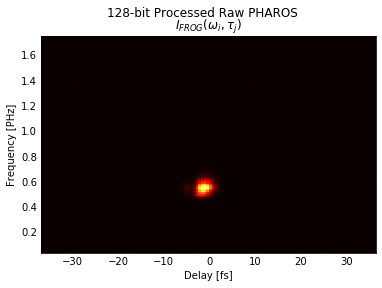

In [3]:
tst.rough_plot(trc,d_arr,f_arr,title='128-bit Processed Raw PHAROS')

In [4]:
# useful params of trace/arrays, dt,df,N,etc
N = trc.shape[0] # trace dim, NxN
dt = np.diff(d_arr)[0] # delay spacing btwn pnts [s]
df = np.diff(f_arr)[0] # freq spacing btwn pnts [Hz]

In [5]:
# start just making functions for each step
def apply_frog(ftEs,m_trace):
    '''
    applies the measured FROG trace to the current iteration's generated E_sig(omega,tau) to generate the improved E'_sig(omega,tau), aka eqn 8.4 in Trebino's book
    this is the general function but within my overal FROG algorithm, it will be utilized with a partial funct
    inputs:
    ftEs -
    m_trace - 
    outputs:
    ftEs_p - 
    '''
    # asserts (later) shape must be same
    ftEs_p = (ftEs/np.abs(ftEs))*np.sqrt(m_trace)
    return ftEs_p
# this will be in the main funct
af = partial(apply_frog,m_trace=trc)
af.__doc__ = 'funct apply_frog, but partial-ed to specific trace being used'

In [6]:
def pulse2sig(pulse,delay):
    '''
    takes the pulse E(t) and returns the time-domain SHG signal, Esig(t,tau)
    * dont need time b/c using tau-tau will cover all the time vals
    '''
    # asserts (later) len of pulse and delay must be same
    p_spl = intp.InterpolatedUnivariateSpline(time,pulse,ext='zeros') # replace extrapol w/ 0s
    # just allocate space rather than for loops, plus then all the arrays are like trace already
    N = len(delay)
    tgrid = np.zeros((N,N)) # time-delay grid [s] tgrid_ij = t_i - tau_j
    gp = np.zeros_like(tgrid) # gate pulse gp_ij = E(ti-tauj) so [[E(t_i-tau)],[E(t_i+1-tau)],etc]
    Es = np.zeros_like(gp) # SHG signal Esig(t,tau), t->omega so works the same way
    # fill the bois
    tgrid = np.array([[delay[i]-delay[j] for j in range(N)] for i in range(N)])
    gp = np.array([[p_spl(tgrid[i,j]) for j in range(N)] for i in range(N)])
    # ^ dont matter if pnts are ordered whn eval spl, but even if it did, doesnt matter like this
    Es = np.array([[pulse[i]*gp[i,j] for j in range(N)] for i in range(N)])
    return Es

In [13]:
def FTsig(signal,dt,N):
    '''
    go from Esig(t,tau) to Esig(omega,tau) via a 1-d FT
    NOTE: using ortho FT convention
    CURRENTLY (8/11/22) DOESNT handle padding with extra zeros, so i would recommend not
    input:
    signal -
    dt - 
    N - 
    output:
    ftEs - 
    ft_freq - not the same as the processed freqs (f_arr)
    '''
    # assert, idk yet
    return

In [23]:
def sig2trc(ftEs):
    '''
    computes the kth calculated trace from the kth Es(omega,tau) for use in G error
    not partial'ed b/c ftEs changes every iteration and is only input
    input:
    ftEs - 
    output:
    c_trace - 
    '''
    return np.abs(ftEs)**2
# might want to call this funct within others, unsure currently

In [11]:
def g_err(m_trace,c_trace):
    '''
    calculated the G error for the kth iteration of the FROG algorithm
    this quantity will be the error that defines convergence and will cause the overall program to stop once it gets low enough
    calls mu_factor within funct
    inputs:
    m_trace - 
    c_trace - 
    outputs:
    Gk - 
    '''
    # assert, trace shapes (if not in mu_factor)
    # get factors
    N = m_trace.shape[0]
    mu = mu_factor(m_trace,c_trace)
    # calc gk
    # asssert that gk will stay real either before w/ stuff in sum or after w/ dtype check
    gk = np.sqrt(np.sum((m_trace - mu*c_trace))/(N**2))
    return gk

In [9]:
def mu_factor(m_trace,c_trace):
    '''
    calculates the scale factor, mu, for the kth iteration of the FROG algorithm
    NOTE: currently (8/15/22), as i understand, this is to be re-calculated for every iteration, this may change as my understanding changes
    inputs:
    m_trace - 
    c_trace - 
    outputs:
    mu_k - 
    '''
    # assertions, trace shapes
    # does np.sum do the right kind of summation, i feel like it may not
    # should i be using np functions or the python magic symbols (check google i guess)
    mu_k = np.divide(np.sum(np.multiply(m_trace,c_trace)),np.sum(np.multiply(c_trace,c_trace)))
    return mu_k

In [20]:
def gen_Ekp1(Es_p,dtau):
    '''
    generates the k+1th E(t) from the kth E'(t,tau) to be used as the pulse in the k+1th FROG cycle
    this is a funct that will be utilized within main program, so it will be partialed
    inputs:
    Es_p - 
    dtau - float
    OR
    delays - array
    NOTE: using np.trapz, can use array or spacing or array, since delays is evenly spaced i wanna go w/ just having spacing since i should probs alrdy have tht
    outputs:
    Ekp1 - 
    '''
    # asserts: if array then check shapes
    # trapz reduces dim of array since it sums along an axis, since delays are horz values need axis=1
    return np.trapz(Es_p,dx=dtau,axis=1)

In [22]:
a = np.linspace(-5.,5.,11) # t
b = np.linspace(-5.,5.,11) # tau
c = np.array([0,1.,2,3,4,5,4,3,2,1,0]) # pulse
grid = np.array([[a[i]-b[j] for j in range(len(b))] for i in range(len(a))]) # t-tau
spl = intp.InterpolatedUnivariateSpline(a,c,ext='zeros')
gp = np.array([[spl(grid[i,j]) for j in range(len(b))] for i in range(len(a))])
sig = np.array([[c[i]*gp[i,j] for j in range(len(b))] for i in range(len(a))])

In [58]:
(fft.fftfreq(N,dt))

array([ 0.00000000e+00,  1.35401555e+13,  2.70803110e+13,  4.06204666e+13,
        5.41606221e+13,  6.77007776e+13,  8.12409331e+13,  9.47810886e+13,
        1.08321244e+14,  1.21861400e+14,  1.35401555e+14,  1.48941711e+14,
        1.62481866e+14,  1.76022022e+14,  1.89562177e+14,  2.03102333e+14,
        2.16642488e+14,  2.30182644e+14,  2.43722799e+14,  2.57262955e+14,
        2.70803110e+14,  2.84343266e+14,  2.97883421e+14,  3.11423577e+14,
        3.24963732e+14,  3.38503888e+14,  3.52044043e+14,  3.65584199e+14,
        3.79124355e+14,  3.92664510e+14,  4.06204666e+14,  4.19744821e+14,
        4.33284977e+14,  4.46825132e+14,  4.60365288e+14,  4.73905443e+14,
        4.87445599e+14,  5.00985754e+14,  5.14525910e+14,  5.28066065e+14,
        5.41606221e+14,  5.55146376e+14,  5.68686532e+14,  5.82226687e+14,
        5.95766843e+14,  6.09306998e+14,  6.22847154e+14,  6.36387309e+14,
        6.49927465e+14,  6.63467620e+14,  6.77007776e+14,  6.90547931e+14,
        7.04088087e+14,  

In [54]:
fft.fftshift(fft.fft(sig,axis=1,norm='ortho'),axes=0)

array([[ 3.01511345e+01 -0.j        , -1.42838437e+01 +4.19411493j,
         2.75516087e-01 -0.17706344j, -1.14416388e+00 +1.3204355j ,
         1.76983200e-01 -0.38753915j, -1.00058950e-01 +0.69592528j,
        -1.00058950e-01 -0.69592528j,  1.76983200e-01 +0.38753915j,
        -1.14416388e+00 -1.3204355j ,  2.75516087e-01 +0.17706344j,
        -1.42838437e+01 -4.19411493j],
       [ 2.17088168e+01 -0.j        , -8.21615222e+00 +8.4380572j ,
        -9.39490821e-01 -0.24312979j,  1.97836120e-01 +0.70845028j,
        -1.21112046e+00 +0.0900219j , -6.85481033e-01 -0.47965917j,
        -6.85481033e-01 +0.47965917j, -1.21112046e+00 -0.0900219j ,
         1.97836120e-01 -0.70845028j, -9.39490821e-01 +0.24312979j,
        -8.21615222e+00 -8.4380572j ],
       [ 1.32664992e+01 -0.j        , -2.77265134e+00 +7.69368845j,
        -1.61367020e+00 +0.5023941j , -7.57322537e-01 -0.19776361j,
        -6.31945885e-01 +0.57090131j, -8.57659624e-01 +0.43556795j,
        -8.57659624e-01 -0.43556795j, 

In [28]:
# print(grid)
# print(gp)
print(sig)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.00000000e+00  5.00000000e+00  4.00000000e+00  3.00000000e+00
   2.00000000e+00  1.00000000e+00 -1.37706218e-17  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.00000000e+00  8.00000000e+00  1.00000000e+01  8.00000000e+00
   6.00000000e+00  4.00000000e+00  2.00000000e+00 -2.75412436e-17
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.00000000e+00  9.00000000e+00  1.20000000e+01  1.50000000e+01
   1.20000000e+01  9.00000000e+00  6.00000000e+00  3.00000000e+00
  -4.13118655e-17  0.00000000e+00  0.00000000e+00]
 [ 4.00000000e+00  8.00000000e+00  1.20000000e+01  1.60000000e+01
   2.00000000e+01  1.60000000e+01  1.20000000e+01  8.00000000e+00
   4.00000000e+00 -5.50824873e-17  0.00000000e+00]
 [ 0.00000000e+00  5.00000000e+00  1.00000000e+01  1.50000000e+01
   2.00000000e+01  